# Vision Transformers for Maize Leaf Disease Detection
The Vision Transformer is a architecture for image classification that employs a Transformer for image patches

## Why Choosing this Project
Google had introduced this with an research article "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" in Oct 2020, but that research is restricted to data_loaders (online API datasets like CIFAR-10). 

This project consists of latest architectures and too challenging to build the customized architecture

## How it is Unique
There is no research articles in either IEEE transcations or any other top journals like springer in real-time

So, I wanted to perform this customized self-trained ViT architectures for real-time custom dataset.
Being the research head, I had gathered the all the information for ViT for image classification.

I had made a build a ViT model and tested it with real time customized dataset.
Conversion of this project to research journal, made me to understand the model architecture in detail.

And now this research is stepping stone to build many research articles for building image classification models for several fields.




### Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

### Importing the UTA Dataset

1. All paths of images of a directory are loaded
2. Images can be read by OpenCV2 or Keras (We Used Keras - Because of )
3. Images are added to X array (Independent variables)
3. As all the images are from a directory, they are labelled same (Y)

In [7]:
import glob
healthy = glob.glob(r'D:\Minor\vit dataset\TRAIN\healthy\*.*') 
diseased = glob.glob(r'D:\Minor\vit dataset\TRAIN\Unhealthy\*.*')
data = []
labels = []
for i in healthy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (720,720))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in diseased:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (720,720))
    image=np.array(image)
    data.append(image)
    labels.append(1)

data = np.array(data)
labels = np.array(labels)

# DataSplit
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

In [8]:
num_classes = 2
input_shape = (720, 720, 3)

x_train = X_train
x_test = X_test
y_train = ytrain
y_test = ytest

### ViT architecture

### Configuration of Hyperparameters 

In [9]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72 # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
 

### Data Augmentation with Keras.Sequential()

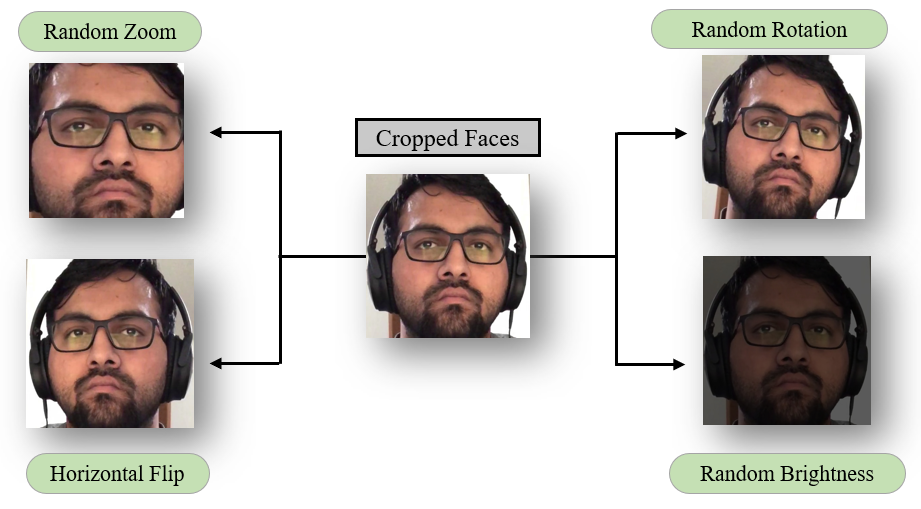

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

### Conversion of images into Patches

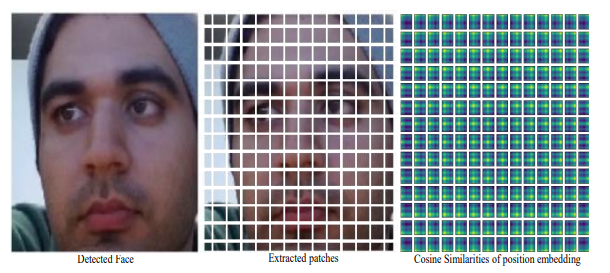


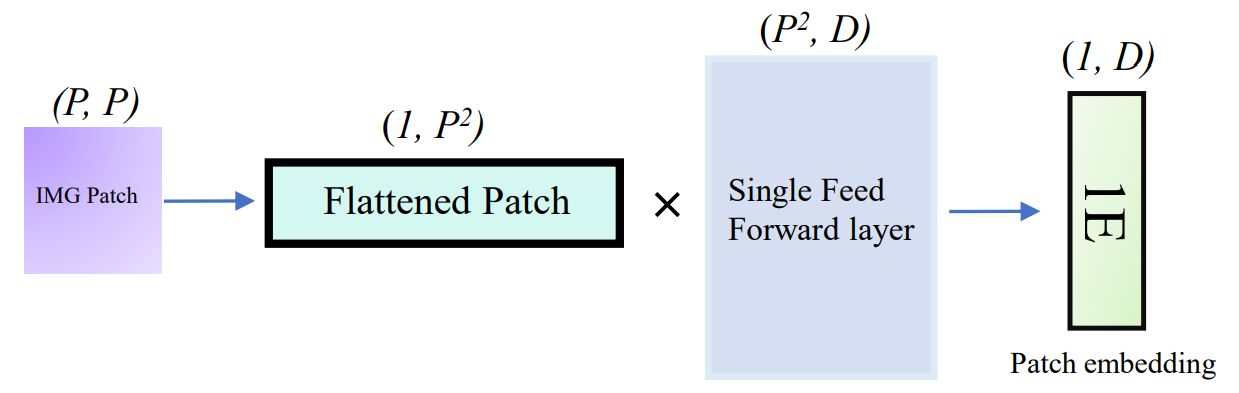

In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 8 X 8
Patches per image: 81
Elements per patch: 192


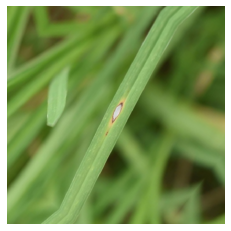

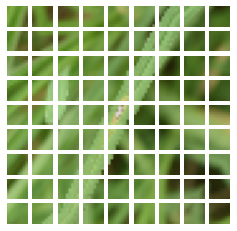

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

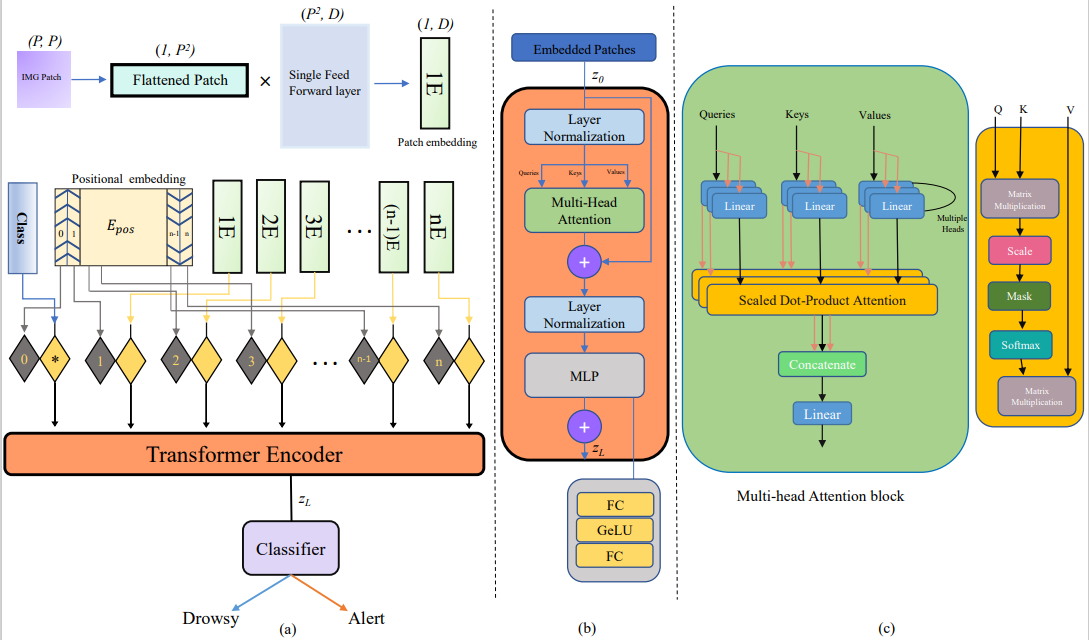

In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

### Training and Validating the Model

In [ ]:
model = create_vit_classifier()
optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
            
    ],
)

checkpoint_filepath = './tmp/checkpoint'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
)

history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
)

Epoch 1/100
7/7 [==============================] - 94s 9s/step - loss: 4.6921 - accuracy: 0.5211 - top-5-accuracy: 1.0000 - val_loss: 2.5366 - val_accuracy: 0.4678 - val_top-5-accuracy: 1.0000
Epoch 2/100
7/7 [==============================] - 62s 9s/step - loss: 1.6989 - accuracy: 0.5556 - top-5-accuracy: 1.0000 - val_loss: 1.3633 - val_accuracy: 0.5906 - val_top-5-accuracy: 1.0000
Epoch 3/100
7/7 [==============================] - 63s 9s/step - loss: 1.2077 - accuracy: 0.6140 - top-5-accuracy: 1.0000 - val_loss: 0.6721 - val_accuracy: 0.6316 - val_top-5-accuracy: 1.0000
Epoch 4/100
7/7 [==============================] - 64s 9s/step - loss: 0.7527 - accuracy: 0.6511 - top-5-accuracy: 1.0000 - val_loss: 0.5249 - val_accuracy: 0.7485 - val_top-5-accuracy: 1.0000
Epoch 5/100
7/7 [==============================] - 63s 9s/step - loss: 0.6490 - accuracy: 0.6686 - top-5-accuracy: 1.0000 - val_loss: 0.5537 - val_accuracy: 0.7251 - val_top-5-accuracy: 1.0000
Epoch 6/100
7/7 [==================

### Evaluating the Model

In [ ]:
history = history


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

These learning plots doesn't demonstrate a good fit learning algorithm as the validation and training curves both maintain a
point of stability with minimal gap.

This ViT model predicts a 2 values for a single prediction.

1st Value indicates probability of class 0(Drowsy)

In [ ]:
y_pred = model.predict(x_test)
import sys
N = 1824
f = []
def largest(arr):
    for i in range(N):
        f.append(np.argmax(arr[i]))
    return f
y_pred = largest(y_pred)

In [ ]:
from sklearn.metrics import roc_curve, auc,roc_auc_score, confusion_matrix,  plot_confusion_matrix, classification_report,precision_recall_curve, PrecisionRecallDisplay
fpr , tpr , thresholds = roc_curve(y_test, y_pred)

def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 
auc_score=roc_auc_score(y_test, y_pred)
print(auc_score)

In [ ]:
import seaborn as sns
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

We got an accuracy of 80  for just 10 epochs.
When the epochs are increased to 150, we achieved an accuracy of 97.4


This is classification part of driver drowsiness system.
The other parts of the system includes extraction of ROI(faces), training model with maximum epochs, realtime testing

This project is accepted at proceedings of springer conferences.